<a href="https://colab.research.google.com/github/gabrie1-s/cnn-1d/blob/combined_approaches/combined_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from scipy.stats import zscore
import seaborn as sns
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler

In [149]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [150]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)

In [151]:
classes =[]

classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

In [203]:
_, _, y_train, y_valid = train_test_split(signals, classes, test_size=0.15, shuffle=False)

In [204]:
def zs_signals(signals):
  for signal in signals:
    mean = signal.mean()
    std = signal.std()
    
    for i in range(len(signal)):
      signal[i] = (signal[i] - mean)/std

  return signals

In [205]:
lstm_train = np.load("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/lstm_train.npy")
lstm_valid = np.load("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/lstm_valid.npy")

spectral_train = np.load("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/spectral_train.npy")
spectral_valid = np.load("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/spectral_valid.npy")

sensible_train = np.load("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/sensible_train.npy") 
sensible_valid = np.load("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/sensible_valid.npy")

cnn1d_train = np.load("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/cnn1d_train.npy")
cnn1d_valid = np.load("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/cnn1d_valid.npy")

In [206]:
lstm_train = zs_signals(lstm_train)
lstm_valid = zs_signals(lstm_valid)

# spectral_train = zs_signals(spectral_train)
# spectral_valid = zs_signals(spectral_valid)

cnn1d_train = zs_signals(cnn1d_train)
cnn1d_valid = zs_signals(cnn1d_valid)

scaler = StandardScaler()
sensible_train = scaler.fit_transform(sensible_train)
scaler = StandardScaler()
sensible_valid = scaler.fit_transform(sensible_valid)

<ipython-input-204-8fc5271677dc>:7: RuntimeWarning: invalid value encountered in float_scalars
  signal[i] = (signal[i] - mean)/std


In [207]:
def combine(models_vec, len):
  entry = []
  for i in range(len):
    val = []

    for model in models_vec:
      val += list(model[i])

    entry.append(val)
    
  return entry  

In [208]:
train_len = len(sensible_train)
models_vec_t = [sensible_train, spectral_train, cnn1d_train, lstm_train]

x_train = combine(models_vec_t, train_len)

In [209]:
val_len = len(sensible_valid)
models_vec_v = [sensible_valid, spectral_valid, cnn1d_valid, lstm_valid]

x_valid = combine(models_vec_v, val_len)

In [210]:
def convert_y(y):
  y = pd.DataFrame(y)
  y = pd.get_dummies(y)
  y = np.array(y)
  return y

In [211]:
y_train = convert_y(y_train)
y_valid = convert_y(y_valid)

In [212]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [213]:
import xgboost as xgb

In [214]:
xgb_cl = xgb.XGBClassifier()

xgb_cl.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [215]:
y_pred = xgb_cl.predict(x_valid)

In [216]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['A', 'N', 'O', '~']
y_pred = y_pred.idxmax(axis=1)

In [217]:
y_valid = pd.DataFrame(y_valid)
y_valid.columns = ['A', 'N', 'O', '~']
y_valid = y_valid.idxmax(axis=1)

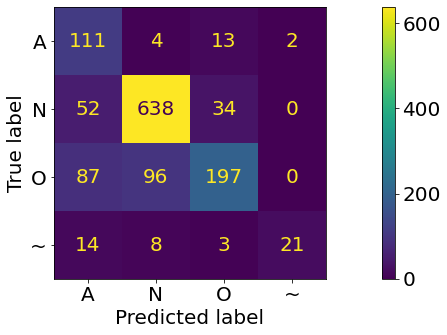

In [218]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

plt.rcParams['figure.figsize']=(20,5)
plt.rcParams.update({'font.size': 20})

cf_matrix = confusion_matrix(y_valid, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O', '~'])
cm_display.plot()

In [219]:
from sklearn.metrics import classification_report 
 
relatorio = classification_report(y_valid, y_pred, target_names = ['A', 'N', 'O', '~']) 
print(relatorio)

              precision    recall  f1-score   support

           A       0.42      0.85      0.56       130
           N       0.86      0.88      0.87       724
           O       0.80      0.52      0.63       380
           ~       0.91      0.46      0.61        46

    accuracy                           0.76      1280
   macro avg       0.75      0.68      0.67      1280
weighted avg       0.80      0.76      0.76      1280

